## Important libraries

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-08-11 15:08:03.654437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 15:08:03.654539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 15:08:03.780688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


## Prepare Data

In [2]:
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
categories = ['benign', 'malignant', 'normal']

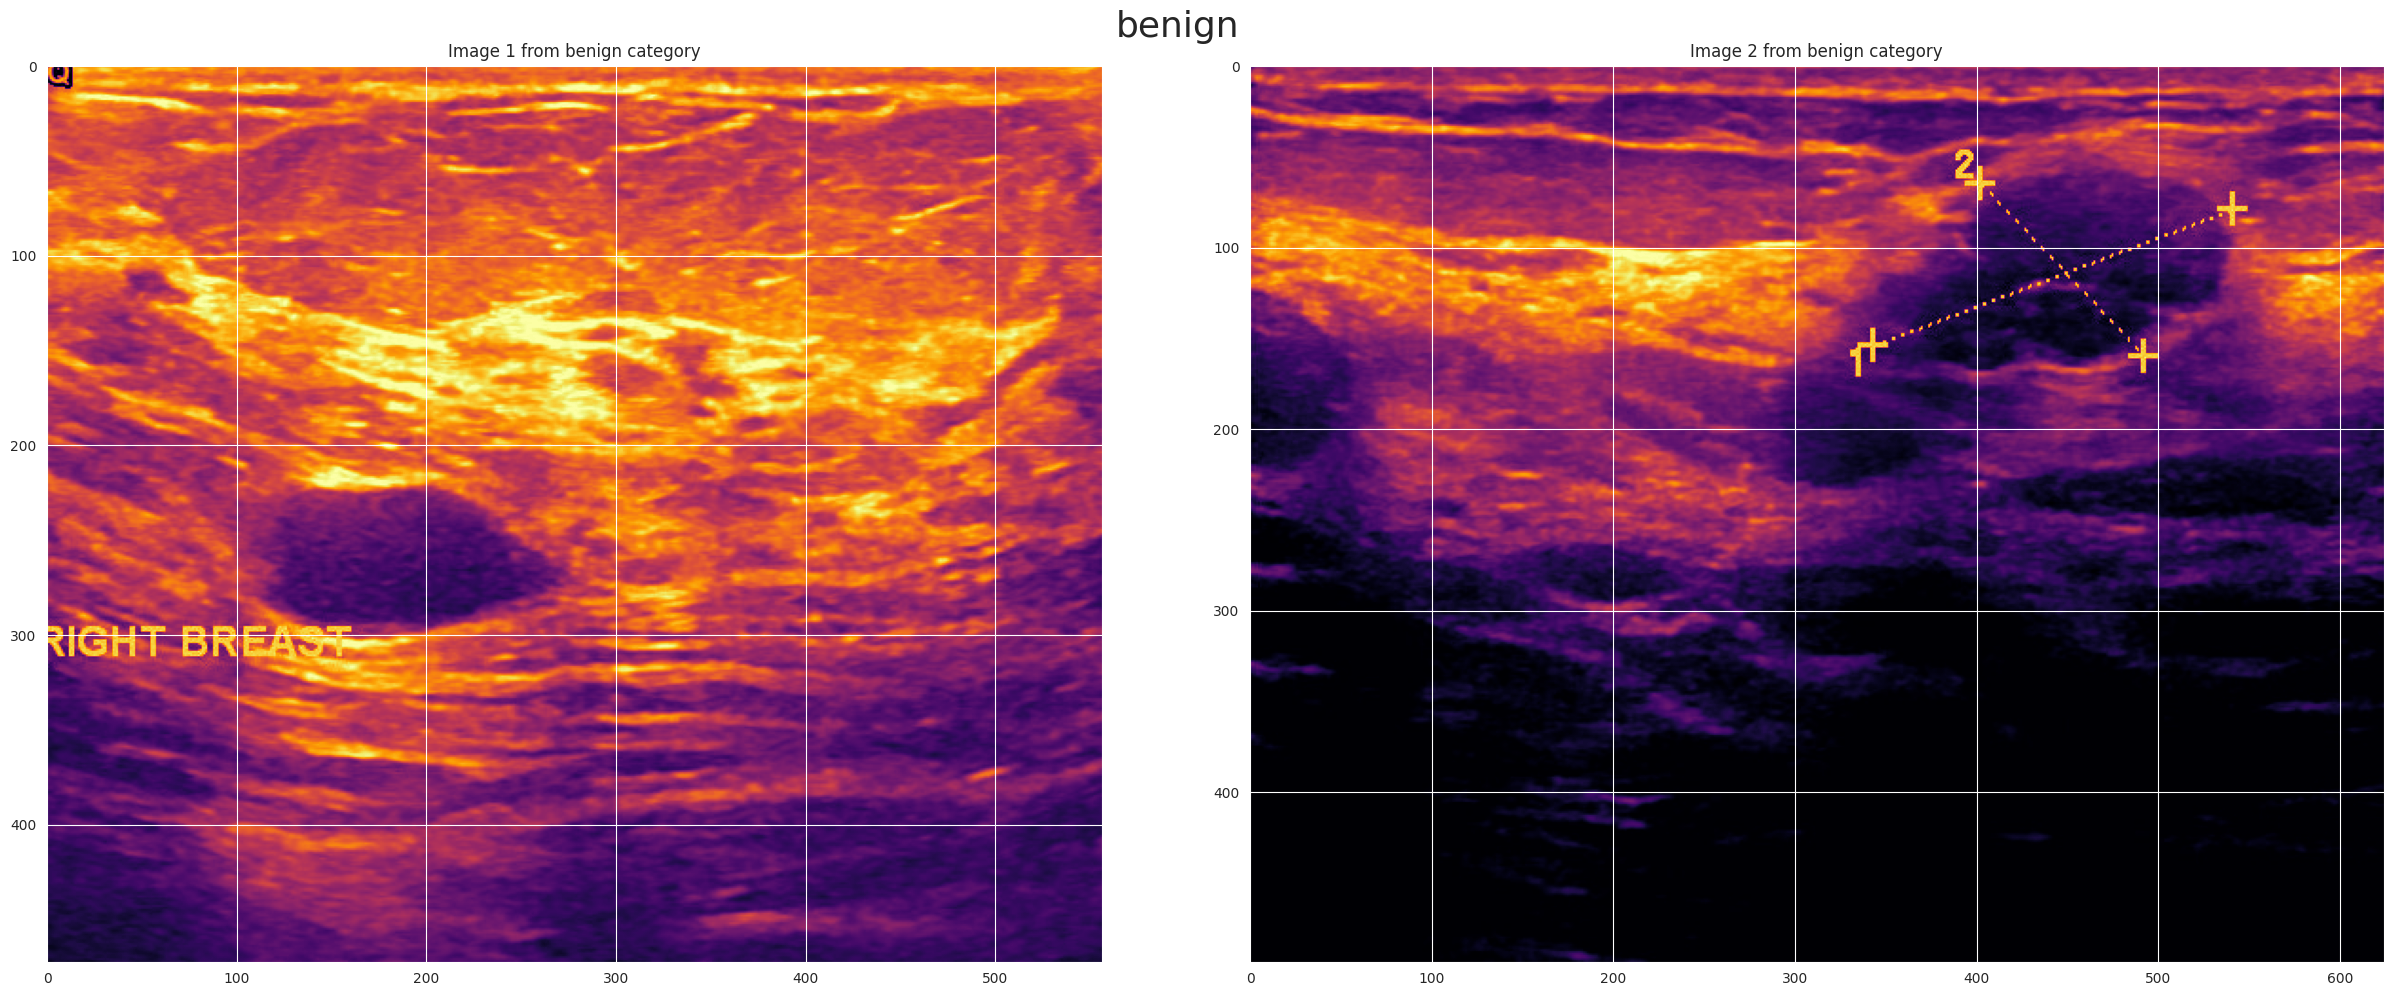

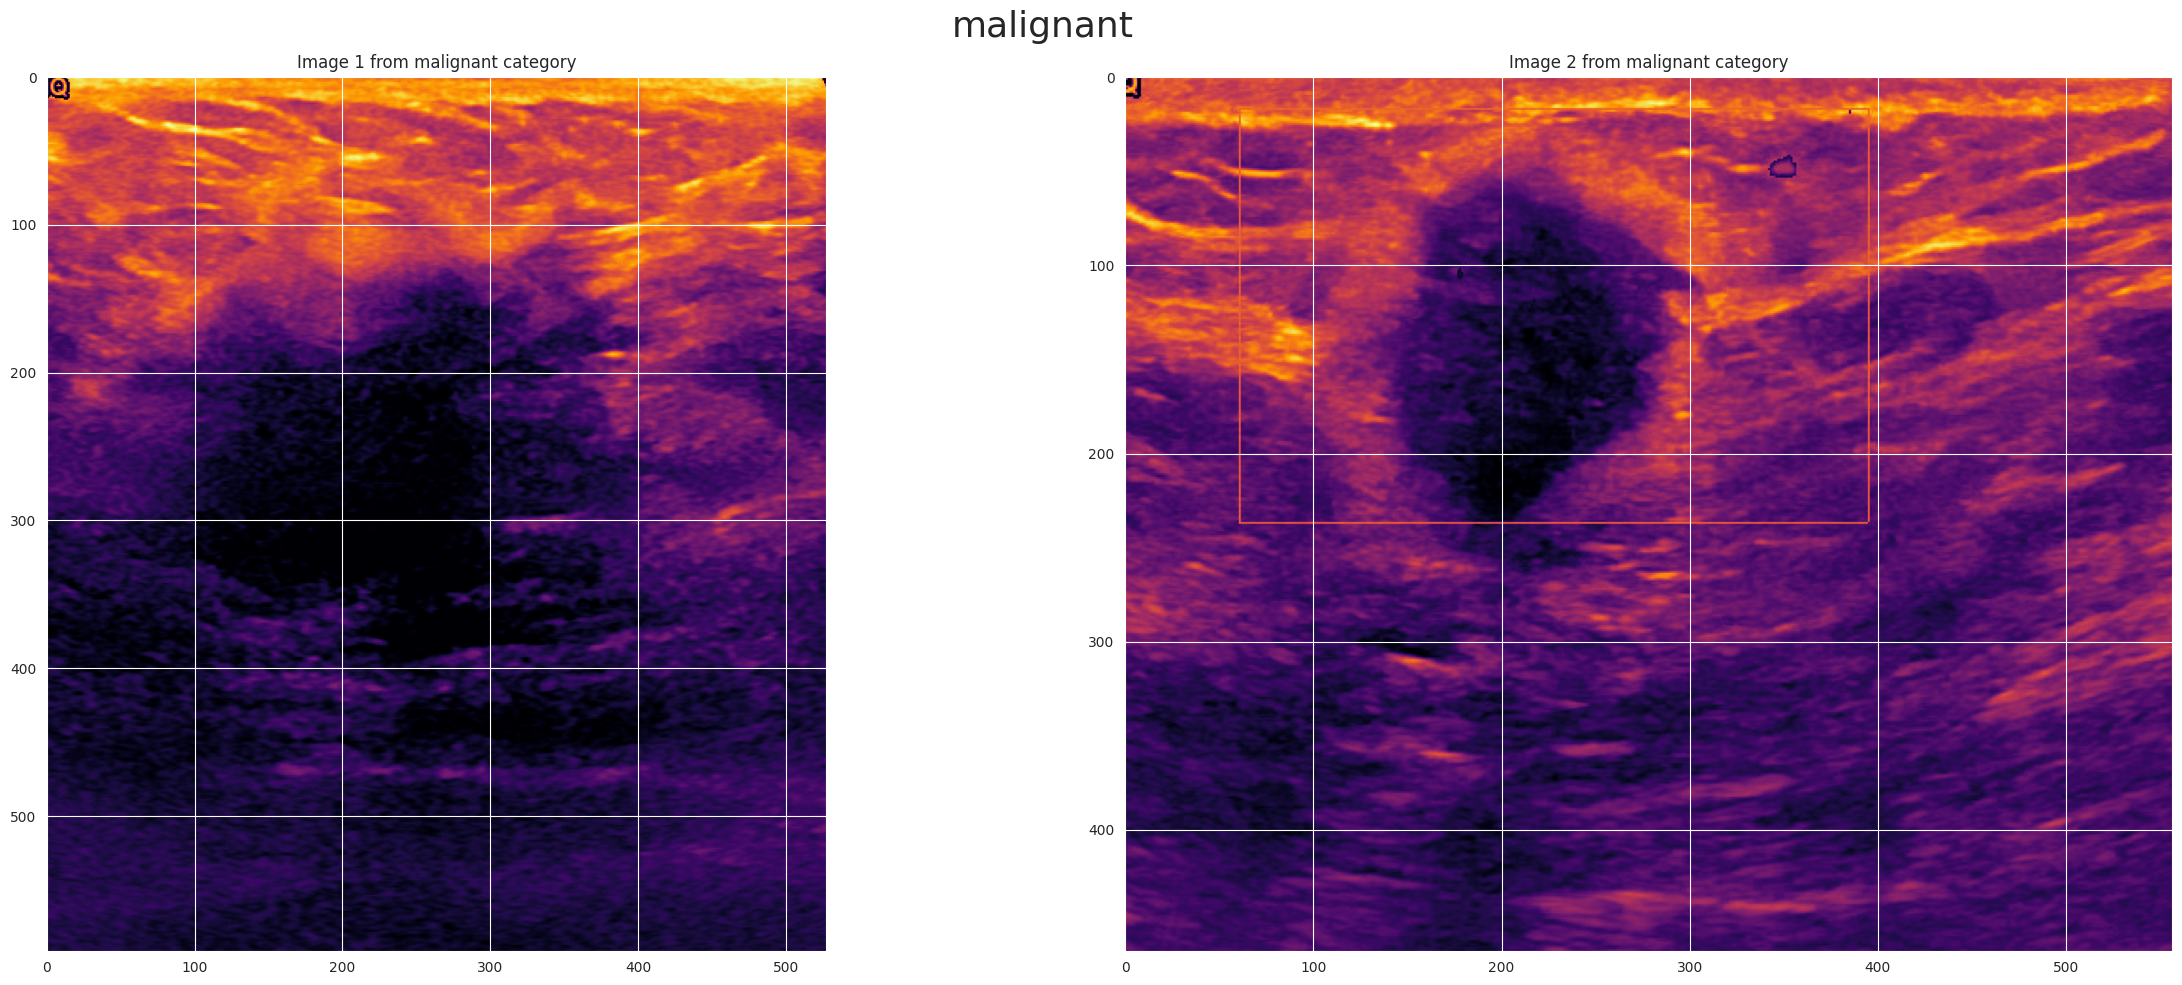

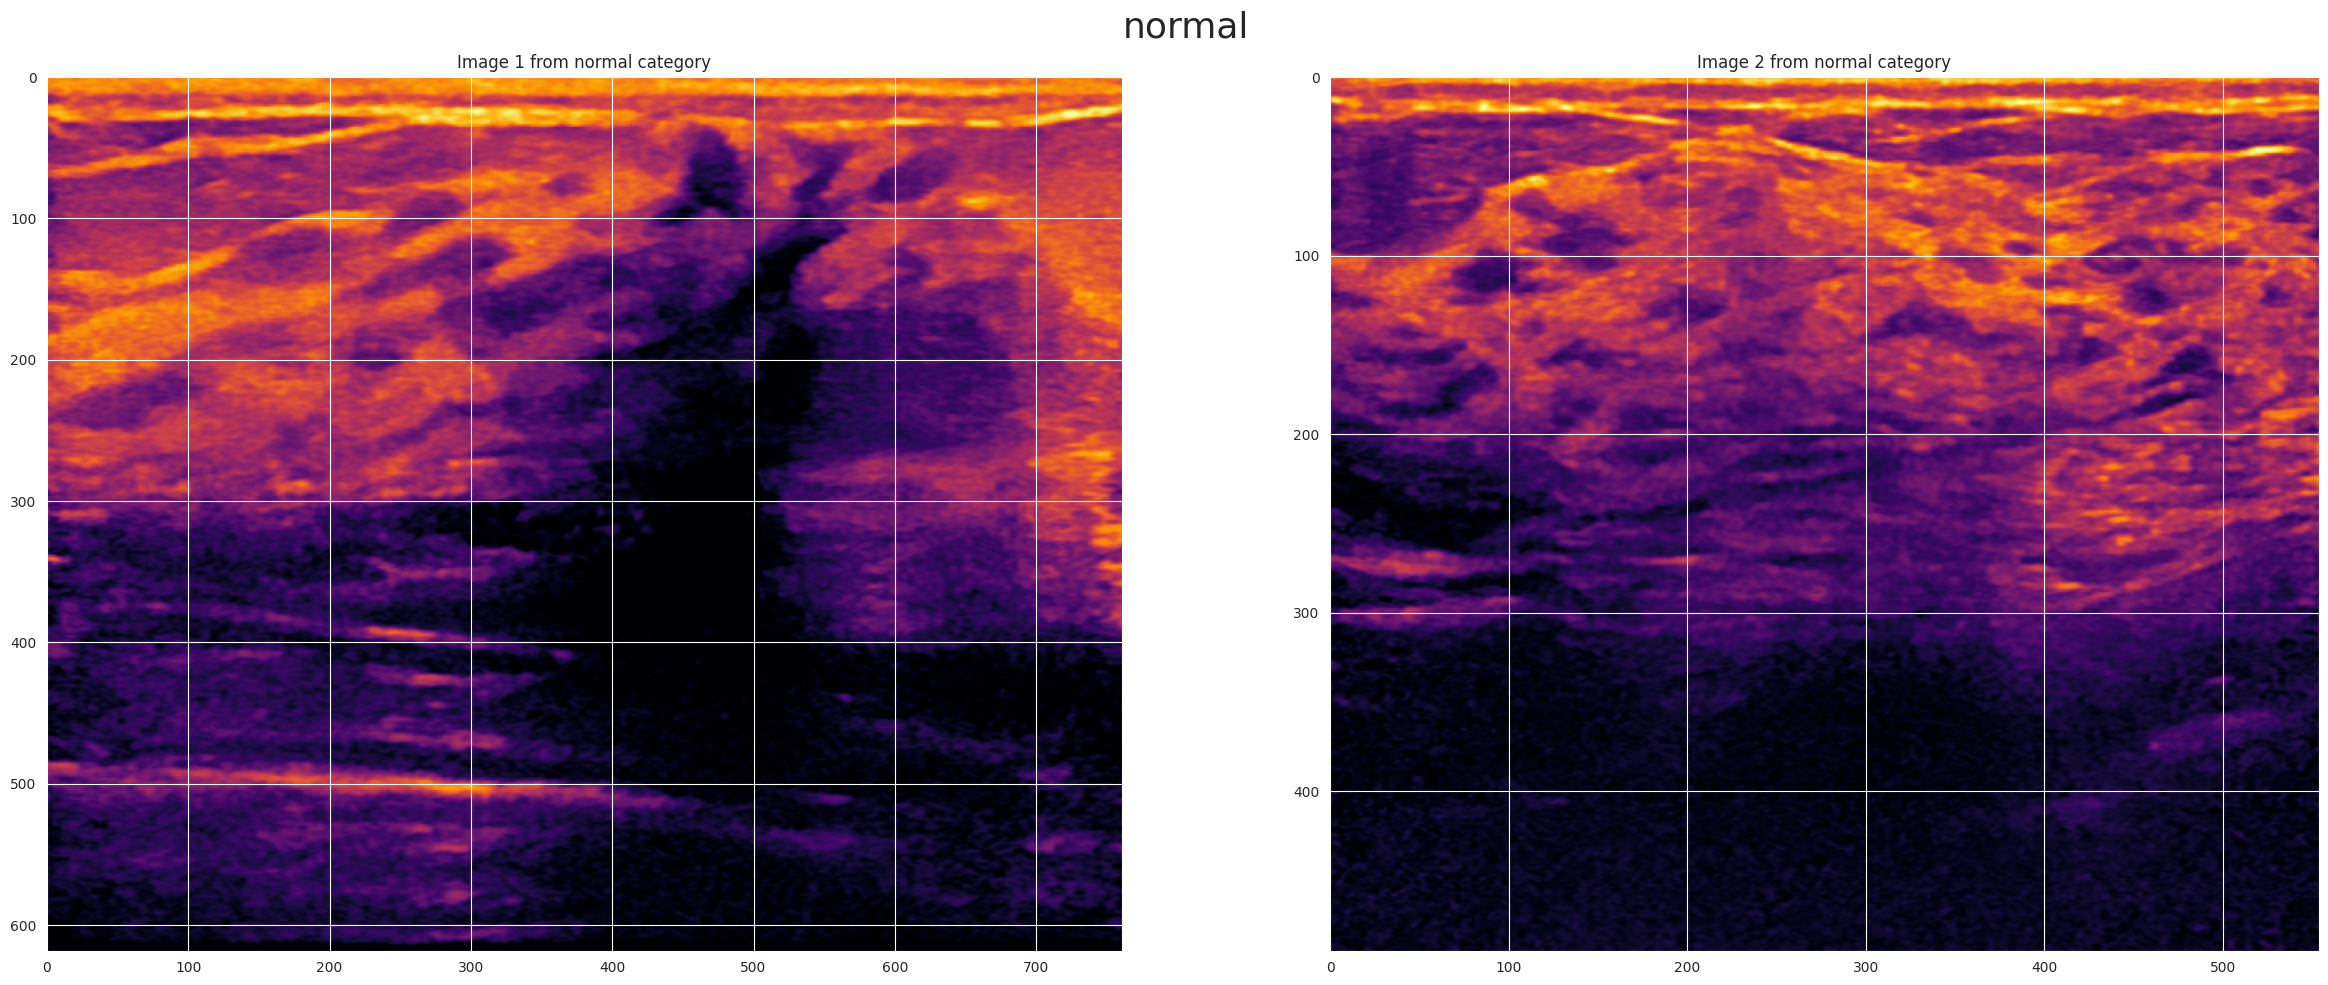

In [3]:
# Display first 2 images from each category with yellow colormap
for category in categories:
    category_path = os.path.join(data_dir, category)
    fig, axs = plt.subplots(1, 2, figsize=(25, 10))

    image_names = os.listdir(category_path)
    idx = 0
    while idx < 2:  # Show only the first 2 images
        image_path = os.path.join(category_path, image_names[idx])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        axs[idx].imshow(image, cmap='inferno')  # Change colormap to yellowish tones
        axs[idx].set_title(f"Image {idx+1} from {category} category")
        idx += 1

    plt.suptitle(category, fontsize=26)
    plt.tight_layout()
    plt.show()


### Generate data paths with labels

In [4]:

filepaths = []
labels = []

In [5]:


folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        


#### Concatenate data paths with labels into one dataframe

In [6]:

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

filepaths     labels
0     /kaggle/input/breast-ultrasound-images-dataset...     benign
1     /kaggle/input/breast-ultrasound-images-dataset...     benign
2     /kaggle/input/breast-ultrasound-images-dataset...     benign
3     /kaggle/input/breast-ultrasound-images-dataset...     benign
4     /kaggle/input/breast-ultrasound-images-dataset...     benign
...                                                 ...        ...
1573  /kaggle/input/breast-ultrasound-images-dataset...  malignant
1574  /kaggle/input/breast-ultrasound-images-dataset...  malignant
1575  /kaggle/input/breast-ultrasound-images-dataset...  malignant
1576  /kaggle/input/breast-ultrasound-images-dataset...  malignant
1577  /kaggle/input/breast-ultrasound-images-dataset...  malignant

[1578 rows x 2 columns]

In [8]:
strat = df['labels']
train_df, test_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 123, stratify= strat)

In [9]:
test_df

filepaths     labels
1024  /kaggle/input/breast-ultrasound-images-dataset...     normal
215   /kaggle/input/breast-ultrasound-images-dataset...     benign
106   /kaggle/input/breast-ultrasound-images-dataset...     benign
339   /kaggle/input/breast-ultrasound-images-dataset...     benign
305   /kaggle/input/breast-ultrasound-images-dataset...     benign
...                                                 ...        ...
1444  /kaggle/input/breast-ultrasound-images-dataset...  malignant
1413  /kaggle/input/breast-ultrasound-images-dataset...  malignant
460   /kaggle/input/breast-ultrasound-images-dataset...     benign
1109  /kaggle/input/breast-ultrasound-images-dataset...     normal
222   /kaggle/input/breast-ultrasound-images-dataset...     benign

[316 rows x 2 columns]

#### crobed image size

In [10]:

batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1262 validated image filenames belonging to 3 classes.
Found 316 validated image filenames belonging to 3 classes.


## Model

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/50


I0000 00:00:1723389049.623916      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723389049.774685      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5660 - loss: 11.5917

W0000 00:00:1723389160.555873      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/158 ━━━━━━━━━━━━━━━━━━━━ 265s 782ms/step - accuracy: 0.5663 - loss: 11.5775 - val_accuracy: 0.7152 - val_loss: 7.5188
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 65s 101ms/step - accuracy: 0.6594 - loss: 6.7248 - val_accuracy: 0.7532 - val_loss: 5.8482
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7389 - loss: 5.5808 - val_accuracy: 0.7658 - val_loss: 4.9101
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.7347 - loss: 4.7192 - val_accuracy: 0.7722 - val_loss: 4.1391
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7579 - loss: 3.9466 - val_accuracy: 0.7658 - val_loss: 3.4508
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7261 - loss: 3.3178 - val_accuracy: 0.8513 - val_loss: 2.8374
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.8119 - loss: 2.7667 - val_accuracy: 0.8449 - val_loss: 2.5137
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8187 - loss: 2.3520 - v

In [13]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9992 - loss: 0.2179
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9616 - loss: 0.3484
Train Loss:  0.21822786331176758
Train Accuracy:  0.999207615852356
--------------------
Test Loss:  0.39440110325813293
Test Accuracy:  0.9430379867553711


In [14]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

W0000 00:00:1723390030.364762      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step


### Confusion matrix

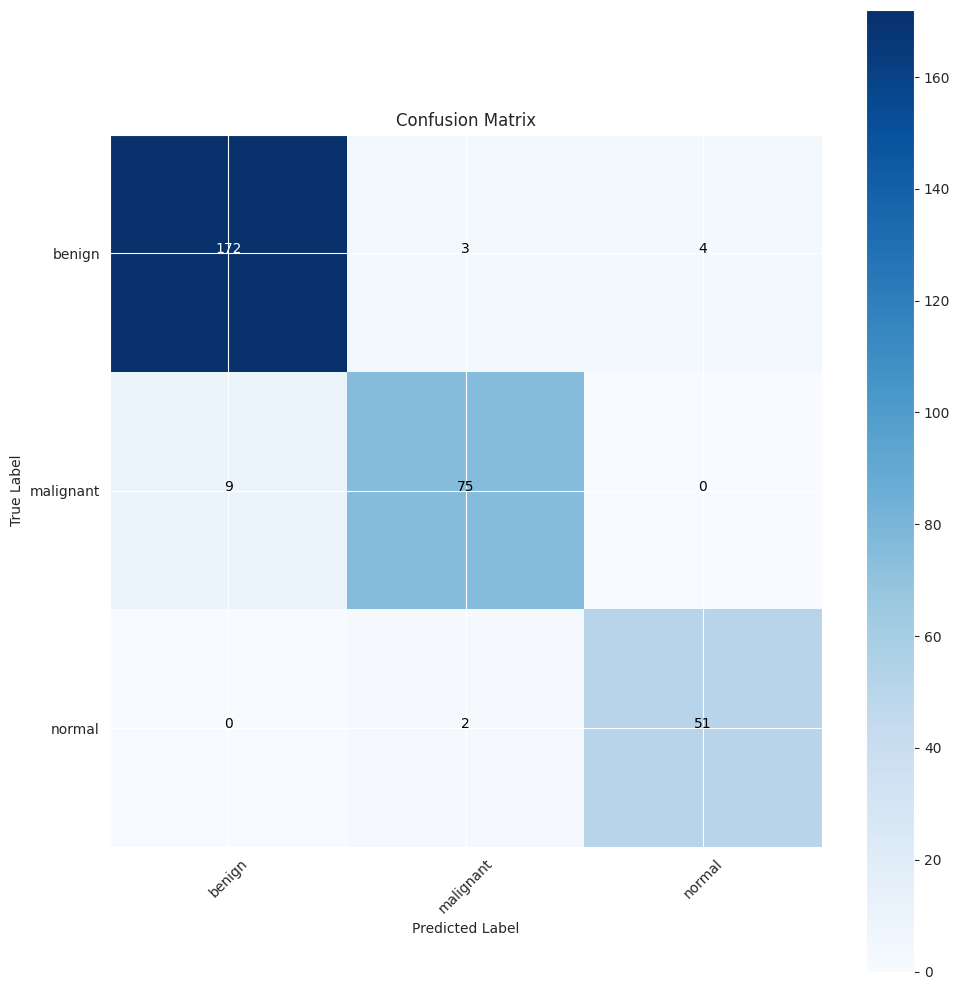

In [15]:

# Assuming g_dict, classes, and cm are already defined
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))

# Modify the colormap (e.g., using 'coolwarm' colormap)
plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


### Classification report

In [16]:

print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.95      0.96      0.96       179
   malignant       0.94      0.89      0.91        84
      normal       0.93      0.96      0.94        53

    accuracy                           0.94       316
   macro avg       0.94      0.94      0.94       316
weighted avg       0.94      0.94      0.94       316



### Save Model

In [17]:

model.save('BreastCancerModel.h5')